final.ipynb

author: Philip Fowler
11 April 2025

This is the final notebook for the machine learning course at NW Missouri State University

In [336]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   
from scipy.stats import norm, skew, boxcox
from scipy import stats, sparse
import statsmodels.api as sm
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
import kagglehub

dont_panic = 42


# Section 1 Import and Inspect the Data

In [337]:
# Download latest version
path = kagglehub.dataset_download("mirichoi0218/insurance")

print("Path to dataset files:", path)

Path to dataset files: /home/philip/.cache/kagglehub/datasets/mirichoi0218/insurance/versions/1


In [338]:
# Load the dataset into a dataframe
file_path = f"{path}/insurance.csv"
df = pd.read_csv(file_path)

# Display the first few rows of the dataframe
df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


In [339]:
# Null values?
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [340]:
# Check the data types of the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [341]:
# check for duplicates
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 1


In [342]:
# drop the one duplicate row
df = df.drop_duplicates()
print(f"Number of duplicate rows after dropping: {df.duplicated().sum()}")

Number of duplicate rows after dropping: 0


Reflection 1: What do you notice about the dataset? Are there any data issues?

This is actually a very clean data set.  I appreciate not have a lot of issues to clean up.

# Section 2 Data Exploration and Preparation

In [343]:
# What are the unique regions?
df['region'].unique()


array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

In [344]:
# Only two values?
df['sex'].unique()

array(['female', 'male'], dtype=object)

In [345]:
# Only two values?
df['smoker'].unique()


array(['yes', 'no'], dtype=object)

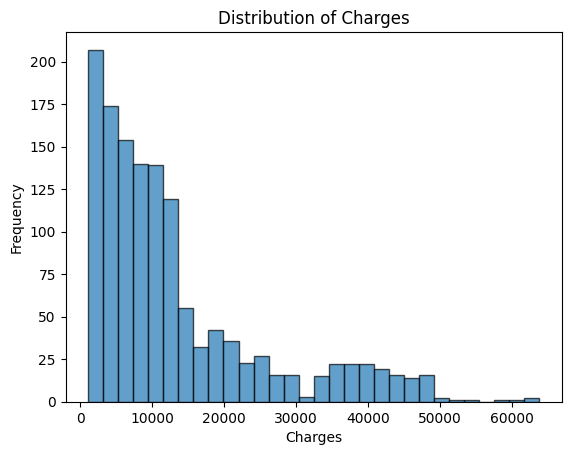

In [346]:
# Make a histogram for the target variable
plt.hist(df['charges'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Charges')
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.show()

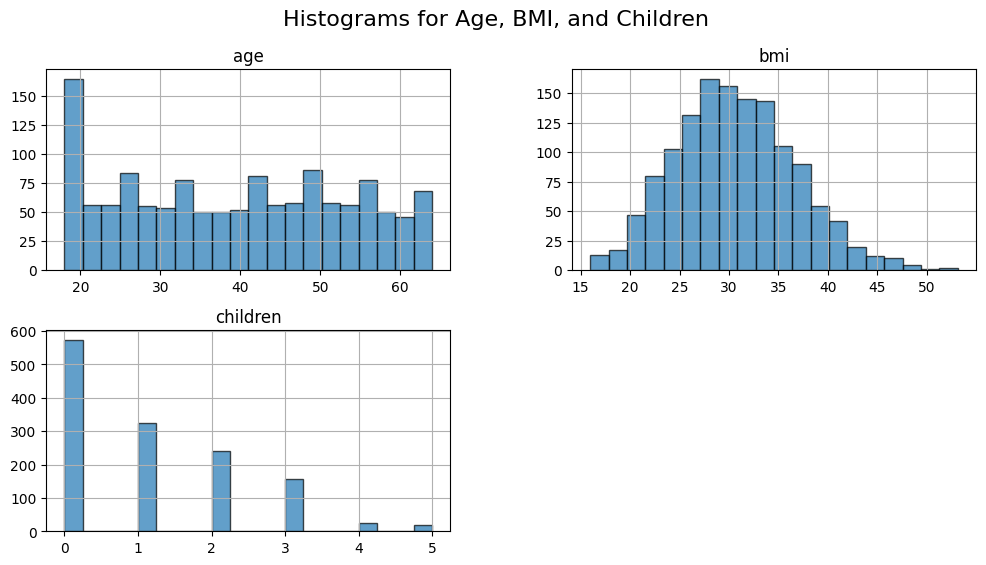

In [347]:
# Create histograms for age, bmi, and children
columns_to_plot = ['age', 'bmi', 'children']
df[columns_to_plot].hist(bins=20, figsize=(12, 6), edgecolor='k', alpha=0.7)

# Add a title to the plot
plt.suptitle('Histograms for Age, BMI, and Children', fontsize=16)
plt.show()

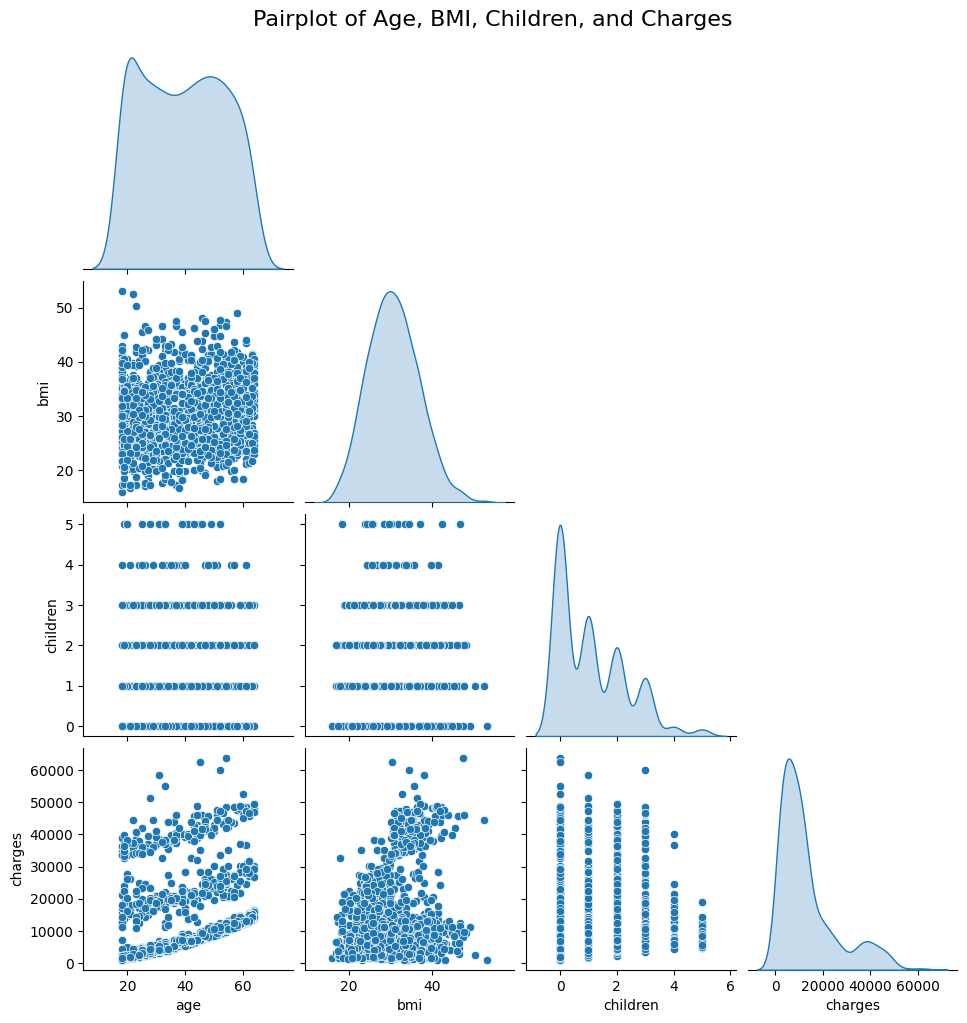

In [348]:
# Create a pairplot for the selected columns
sns.pairplot(df[['age', 'bmi', 'children', 'charges']], diag_kind='kde', corner=True)

# Add a title to the plot
plt.suptitle('Pairplot of Age, BMI, Children, and Charges', y=1.02, fontsize=16)
plt.show()

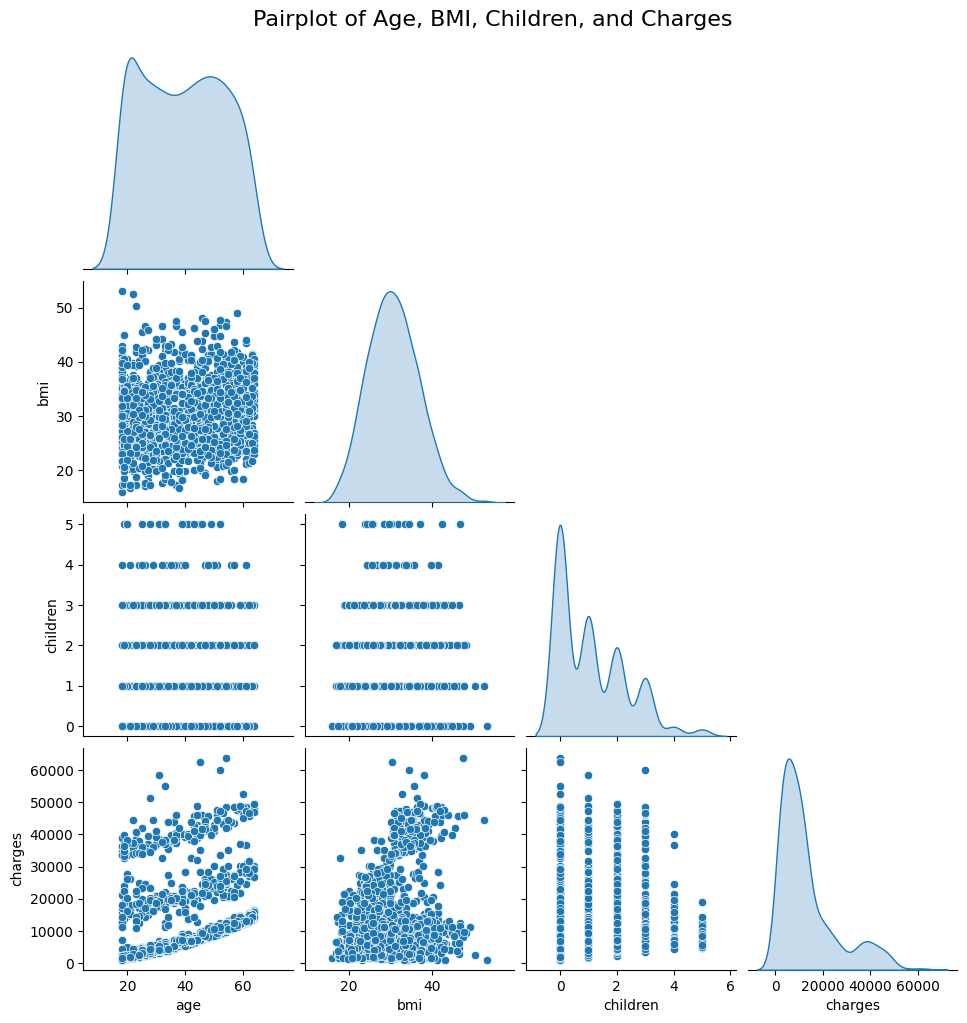

In [349]:
# Create a pairplot for the selected columns
sns.pairplot(df[['age', 'bmi', 'children', 'charges']], diag_kind='kde', corner=True)

# Add a title to the plot
plt.suptitle('Pairplot of Age, BMI, Children, and Charges', y=1.02, fontsize=16)
plt.show()

In [350]:
# Define BMI categories
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 25:
        return 'Normal'
    elif 25 <= bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'

# Apply the function to create the bmi_cat column
df['bmi_cat'] = df['bmi'].apply(categorize_bmi)

# Display the first few rows to verify
df[['bmi', 'bmi_cat']].head()

,bmi,bmi_cat
0,27.900,Overweight
1,33.770,Obese
2,33.000,Obese
3,22.705,Normal
4,28.880,Overweight


In [351]:
# Define age categories
def categorize_age(age):
    if age < 30:
        return 'young_adult'
    elif 30 <= age <= 62:
        return 'adult'
    else:
        return 'pensioner'

# Apply the function to create the age_cat column
df['age_cat'] = df['age'].apply(categorize_age)

# Display the first few rows to verify
df[['age', 'age_cat']].head()

,age,age_cat
0,19,young_adult
1,18,young_adult
2,28,young_adult
3,33,adult
4,32,adult


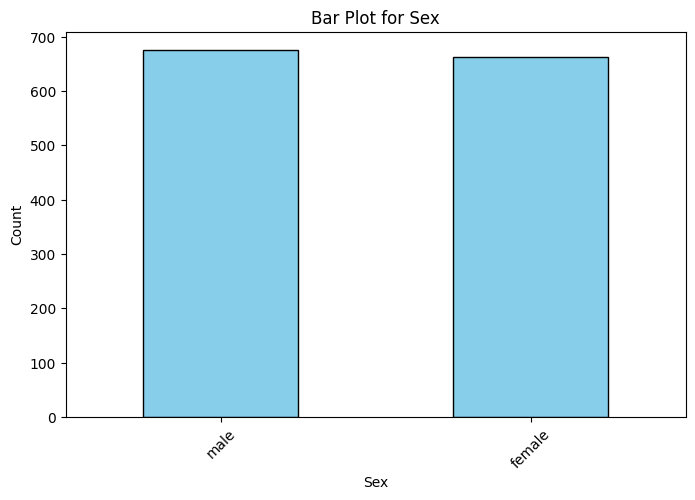

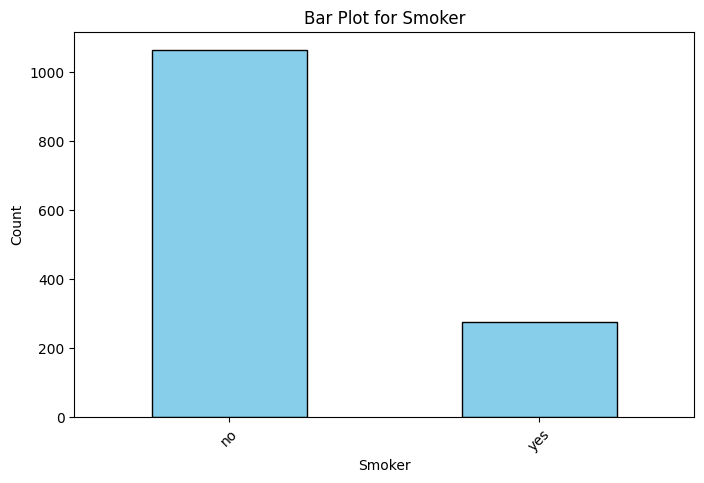

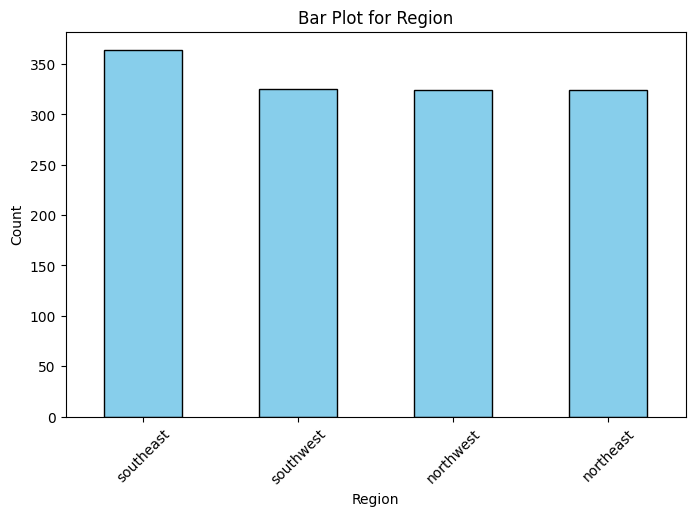

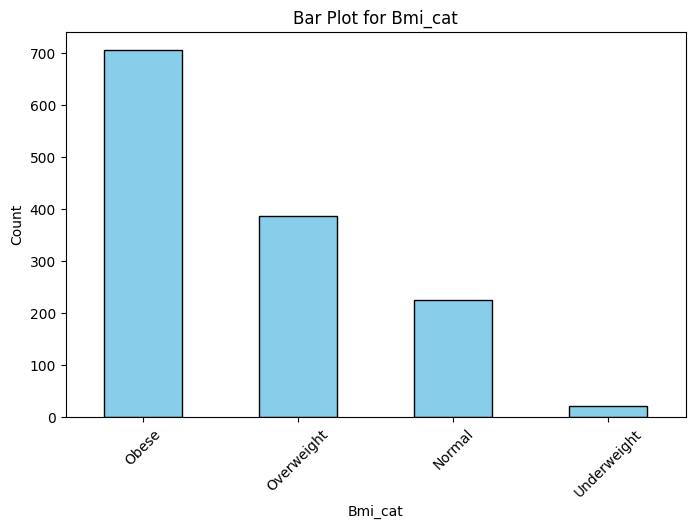

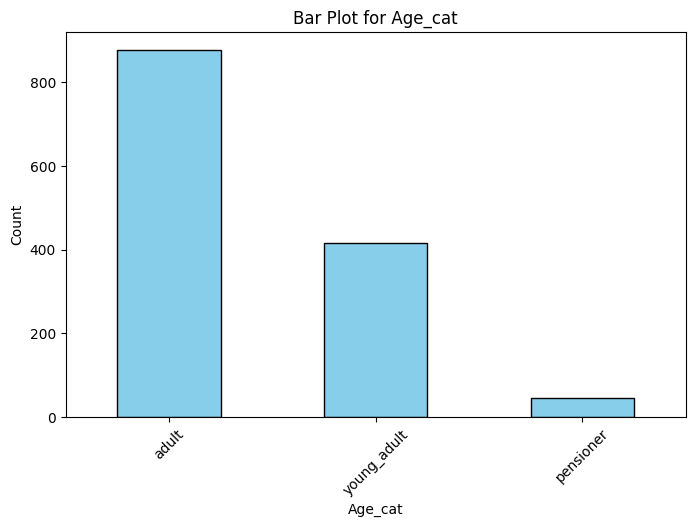

In [352]:
# Create bar plots for categorical variables
categorical_columns = ['sex', 'smoker', 'region', 'bmi_cat', 'age_cat']

for column in categorical_columns:
    plt.figure(figsize=(8, 5))
    df[column].value_counts().plot(kind='bar', color='skyblue', edgecolor='k')
    plt.title(f'Bar Plot for {column.capitalize()}')
    plt.xlabel(column.capitalize())
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

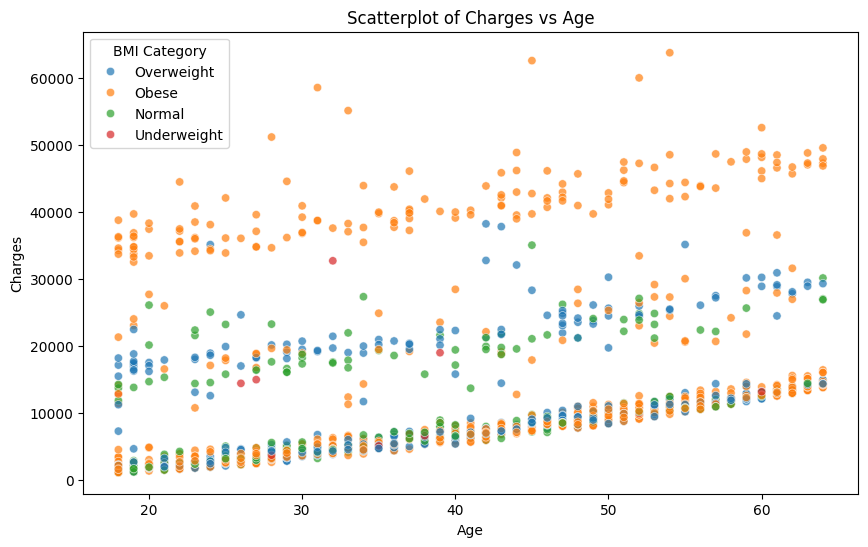

In [353]:
# Create a scatterplot for age vs charges
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='age', y='charges', hue='bmi_cat', alpha=0.7)
plt.title('Scatterplot of Charges vs Age')
plt.xlabel('Age')
plt.ylabel('Charges')
plt.legend(title='BMI Category')
plt.show()

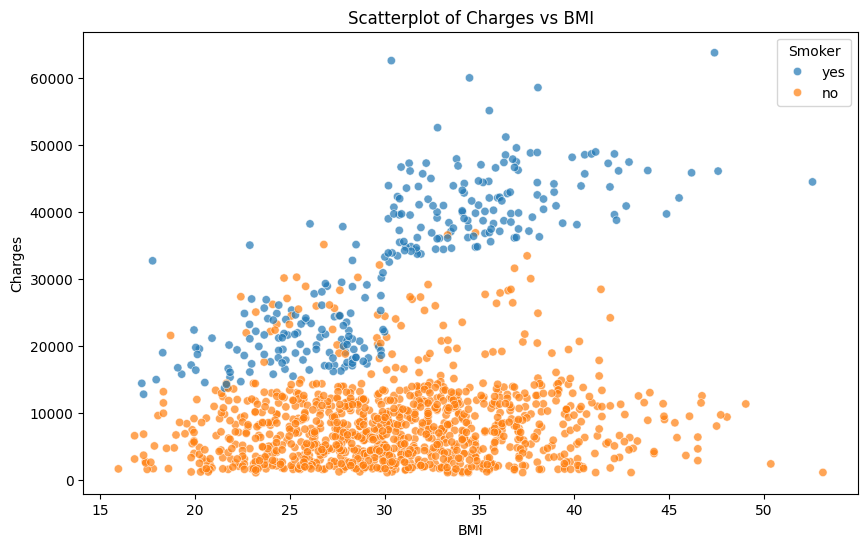

In [354]:
# Create a scatterplot for bmi vs charges
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='bmi', y='charges', hue='smoker', alpha=0.7)
plt.title('Scatterplot of Charges vs BMI')
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.legend(title='Smoker')
plt.show()

I find this plot to be one of the most intruiging of this dataset.  To my mind there are at least two visible groups here.  In the above imagethe smokers are certainly a separate group.  However, what is happening at 30 BMI that also increases the cost?  This is also the cutoff between overweight and obese, which makes me think that there is more to this than just two groups.  It is beginning to become apparent that obesity and smoking are two key factors in increasing medical costs.

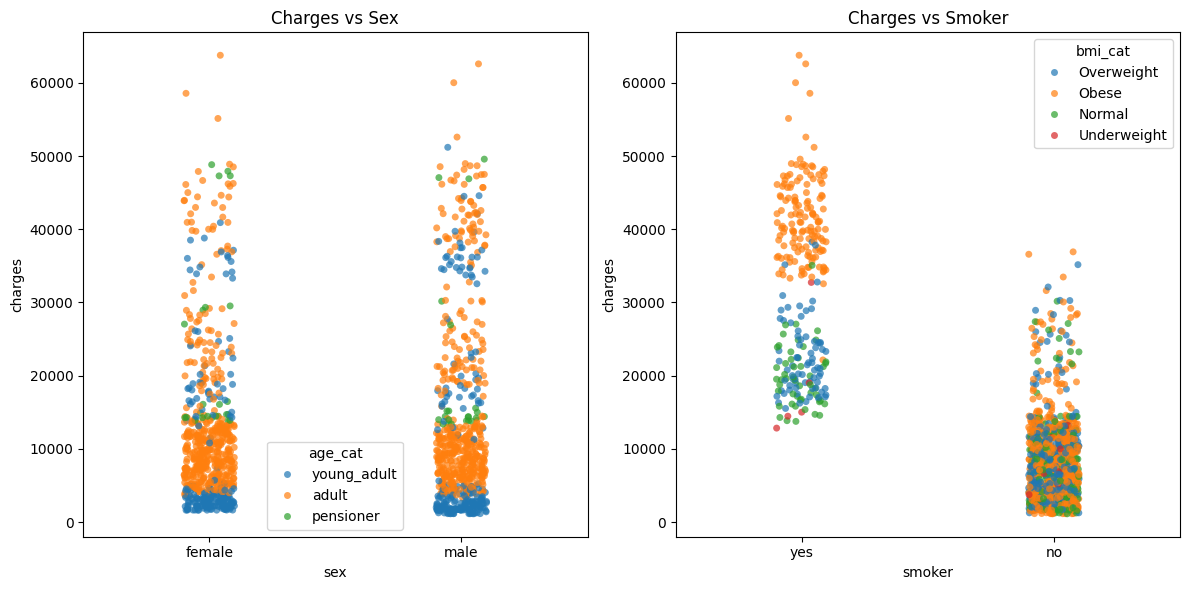

In [355]:
# Strip plot for charges vs sex
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.stripplot(data=df, x='sex', y='charges', jitter=True, hue='age_cat', alpha=0.7)
plt.title('Charges vs Sex')

# Strip plot for charges vs smoker
plt.subplot(1, 2, 2)
sns.stripplot(data=df, x='smoker', y='charges', jitter=True, hue='bmi_cat' ,alpha=0.7)
plt.title('Charges vs Smoker')

plt.tight_layout()
plt.show()

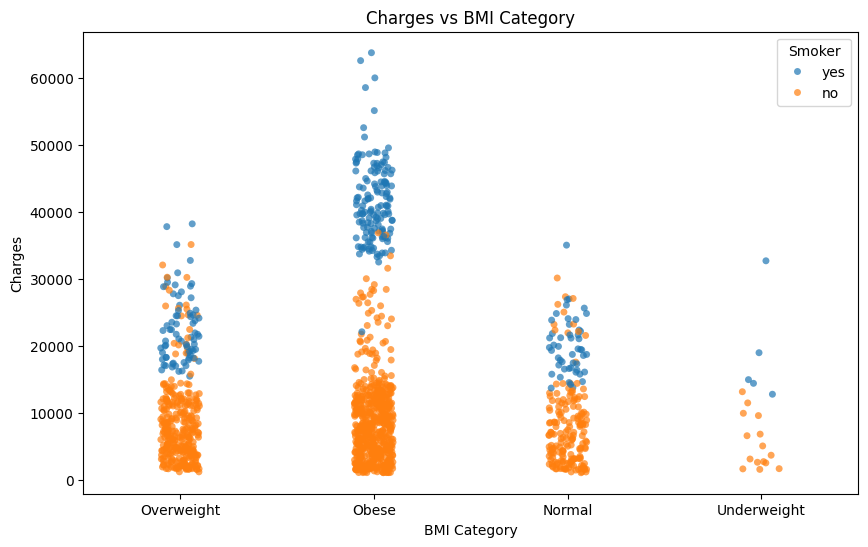

In [356]:
# Strip plot for charges vs bmi_cat
plt.figure(figsize=(10, 6))
sns.stripplot(data=df, x='bmi_cat', y='charges', hue='smoker', jitter=True, alpha=0.7)
plt.title('Charges vs BMI Category')
plt.xlabel('BMI Category')
plt.ylabel('Charges')
plt.legend(title='Smoker')
plt.show()

I want to revisit the pairplot that I used earlier now that I have more insights.  Specifically I am interested in how smoking and bmi are distributed in the data.

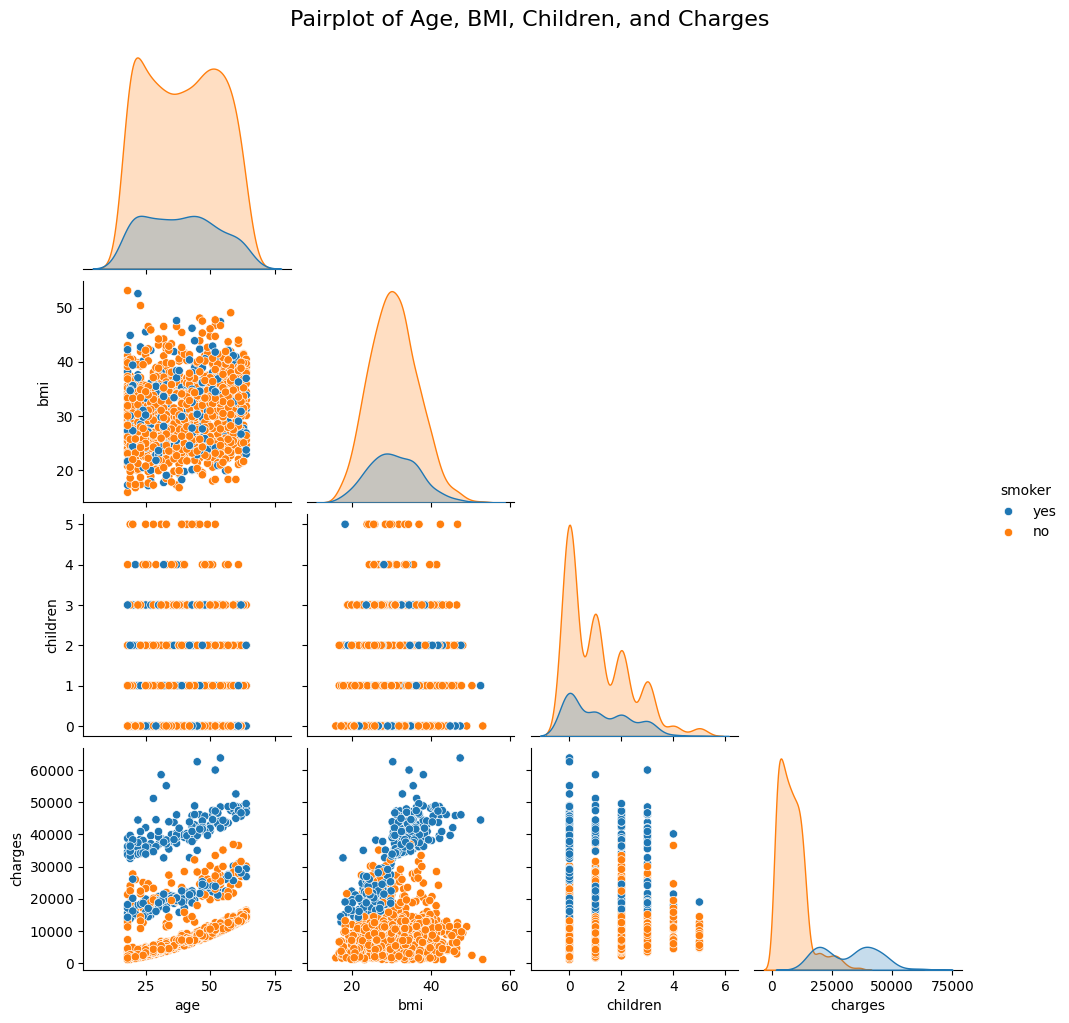

In [357]:
# Create a pairplot for the selected columns
sns.pairplot(df, hue='smoker', diag_kind='kde', corner=True)

# Add a title to the plot
plt.suptitle('Pairplot of Age, BMI, Children, and Charges', y=1.02, fontsize=16)
plt.show()

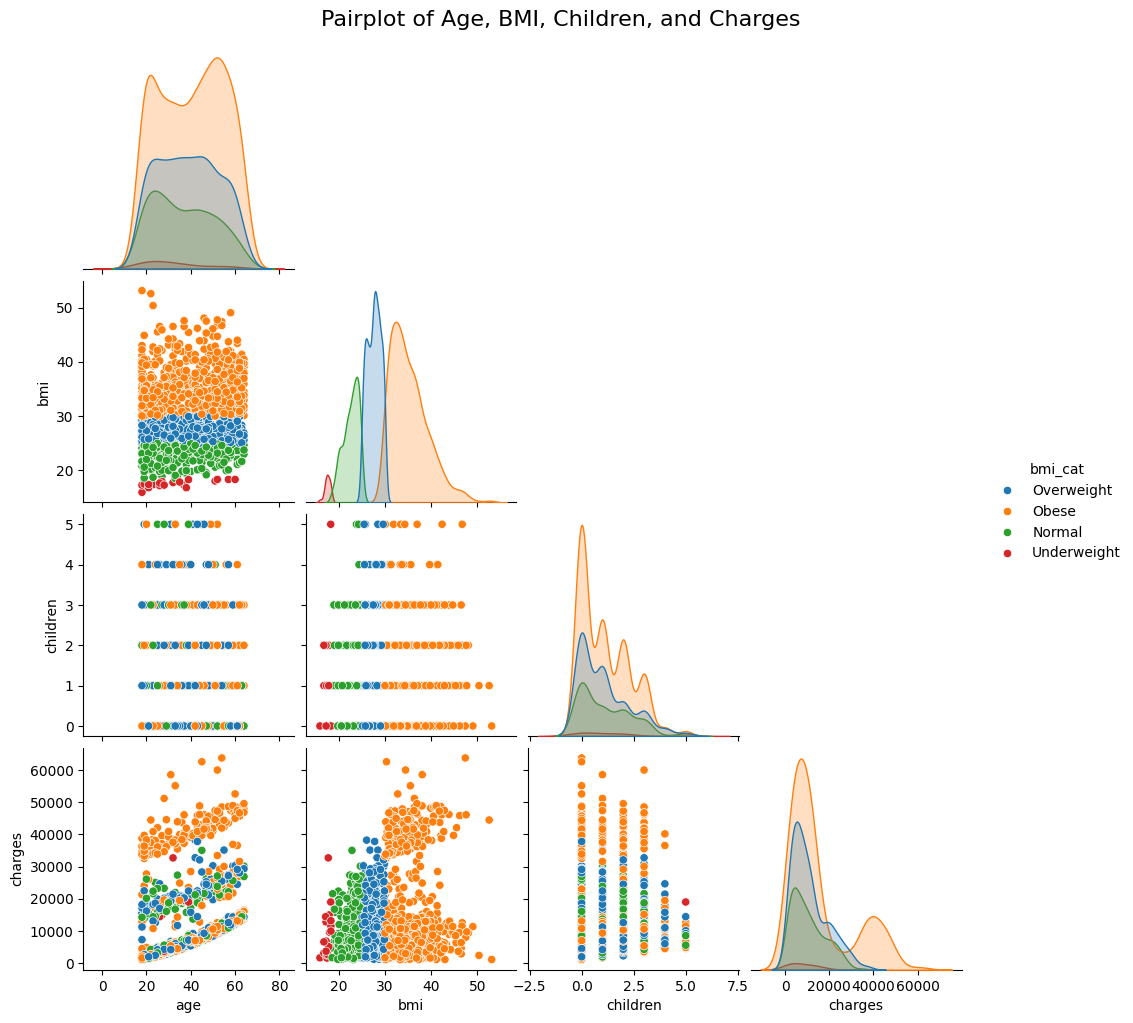

In [358]:
# Create a pairplot for the selected columns
sns.pairplot(df, hue='bmi_cat', diag_kind='kde', corner=True)

# Add a title to the plot
plt.suptitle('Pairplot of Age, BMI, Children, and Charges', y=1.02, fontsize=16)
plt.show()

The BMI vs Charges plots in both of the pairplots are quite enlightening.  It appears that both obesity and smoking are related to higher medical costs.

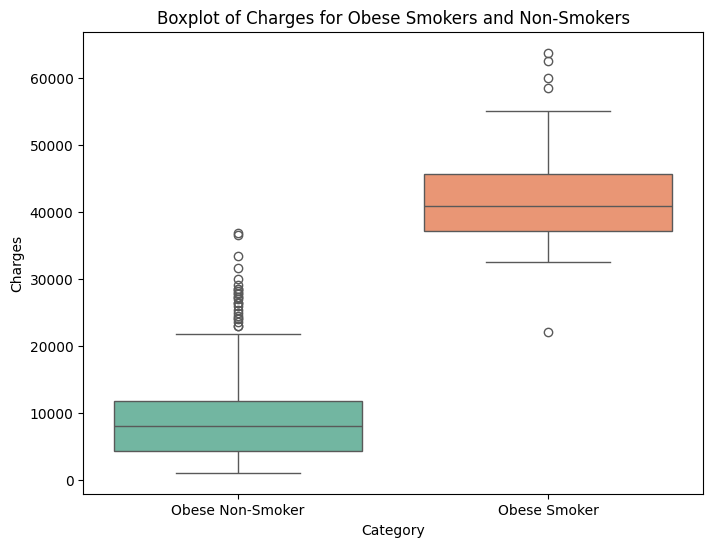

In [359]:
# Filter the dataframe for obese individuals
obese_df = df[df['bmi_cat'] == 'Obese'].copy()  

# Create a new column to categorize obese individuals as smokers or non-smokers
obese_df.loc[:, 'smoker_status'] = obese_df['smoker'].apply(lambda x: 'Obese Smoker' if x == 'yes' else 'Obese Non-Smoker')

# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=obese_df, x='smoker_status', y='charges', hue='smoker', palette='Set2', dodge=False, legend=False)
plt.title('Boxplot of Charges for Obese Smokers and Non-Smokers')
plt.xlabel('Category')
plt.ylabel('Charges')
plt.savefig('images/obese_smoker_boxplot.png')

For the sake of completeness, let's also look at region.  Are there any differences by region?

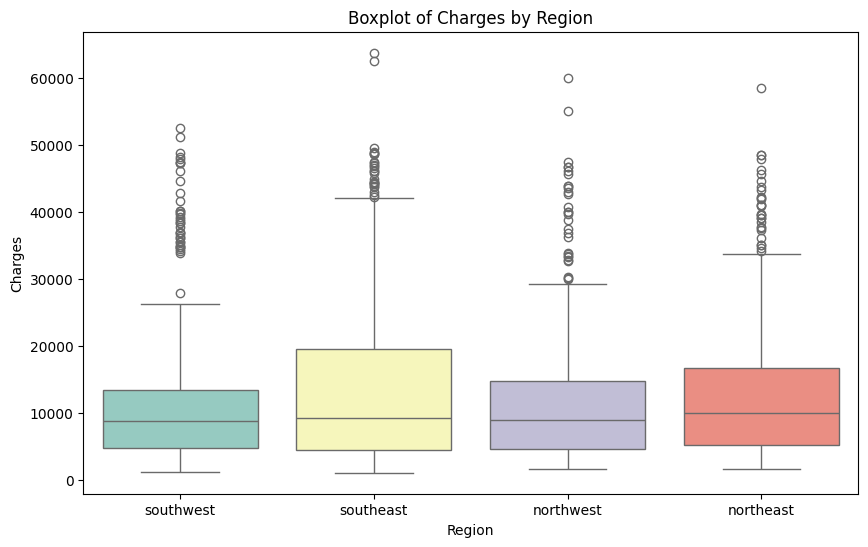

In [360]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='region', y='charges', hue='region', palette='Set3', dodge=False, legend=False)
plt.title('Boxplot of Charges by Region')
plt.xlabel('Region')
plt.ylabel('Charges')
plt.show()

Reflection 2: What patterns or anomalies do you see? Do any features stand out? What preprocessing steps were necessary to clean and improve the data? Did you create or modify any features to improve performance?

 - There are definitely patterns here that can be seen visually.  
 - BMI and Age categories were created.
 - In an upcoming cell I will also one hot encode the categorical variables and scale the charges column.

# Section 3 Feature Selection and Justification



In [361]:
# define the categorical columns
categorical_columns = ['sex', 'smoker', 'region', 'bmi_cat', 'age_cat']

# One-hot encode the categorical columns
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True, prefix='ohe', prefix_sep='_', dtype='int8')

# Rename the specified columns in df_encoded
df_encoded.rename(columns={
    'ohe_yes': 'ohe_smoker',
    'ohe_Obese': 'ohe_obese',
    'ohe_Overweight': 'ohe_overweight',
    'ohe_Underweight': 'ohe_underweight'
}, inplace=True)

# drop the original age and bmi columns
df_encoded = df_encoded.drop(columns=['age', 'bmi'])

# Create an engineered feature called obese_smoker
# df_encoded['obese_smoker'] = df_encoded['ohe_obese'] * df_encoded['ohe_smoker']

# Display the first few rows of the encoded dataframe
df_encoded.head()


,children,charges,ohe_male,ohe_smoker,ohe_northwest,ohe_southeast,ohe_southwest,ohe_obese,ohe_overweight,ohe_underweight,ohe_pensioner,ohe_young_adult
0,0,16884.92400,0,1,0,0,1,0,1,0,0,1
1,1,1725.55230,1,0,0,1,0,1,0,0,0,1
2,3,4449.46200,1,0,0,1,0,1,0,0,0,1
3,0,21984.47061,1,0,1,0,0,0,0,0,0,0
4,0,3866.85520,1,0,1,0,0,0,1,0,0,0


In [362]:
# drop unwanted columns from df encoded
df_encoded = df_encoded.drop(columns=['ohe_southeast', 'ohe_northwest', 'ohe_southwest', 'ohe_overweight', 'ohe_underweight'])

# log transform the charges column
df_encoded['charges'] = np.log1p(df_encoded['charges'])

# box cox transform the charges column - retained in case I change my mind.  Log seems to work better
# df_encoded['charges'] = boxcox(df_encoded['charges'])[0]

Reflection 3: Why did you choose these features? How might they impact predictions or accuracy?

 - The regional columns had no impact on the model.  They were dropped.
 - The charges column was scaled to improve the model.  This was tried with and without scaline.  Log scaling performed the best.
 - Of the BMI categories, the one that present the most value is obesity.  This needs to be binary, as in obese or not obese.  The other categories are not as useful.  Thus, the other variables were dropped.

# Sections 4 and 5 The Models 

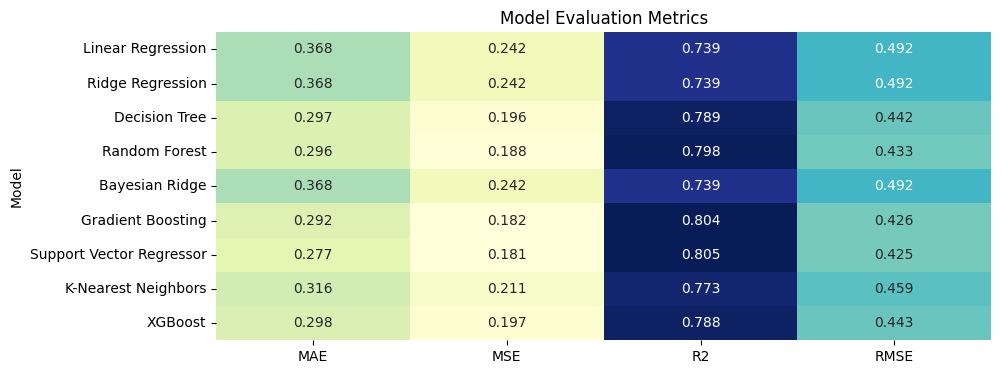

In [363]:
# define the features and target variable
X = df_encoded.drop(columns='charges')
y = df_encoded['charges']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=dont_panic)

# Function to evaluate models
def evaluate_models(models, X_train, y_train, X_test, y_test):
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        results[name] = {
            'MAE': mean_absolute_error(y_test, y_pred),
            'MSE': mean_squared_error(y_test, y_pred),
            'R2': r2_score(y_test, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_test, y_pred))
        }
    return results

# Define the models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Bayesian Ridge': BayesianRidge(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Support Vector Regressor': svm.SVR(),
    'K-Nearest Neighbors': KNeighborsRegressor(),
    'XGBoost': XGBRegressor(),
}

# Evaluate the models
results = evaluate_models(models, X_train, y_train, X_test, y_test)

# Convert the results dictionary into a dataframe
results_df = pd.DataFrame.from_dict(results, orient='index').reset_index()

# Rename the columns for clarity
results_df.columns = ['Model', 'MAE', 'MSE', 'R2', 'RMSE']

# Display the dataframe as a seaborn heatmap
plt.figure(figsize=(10, 4))
sns.heatmap(results_df.set_index('Model'), annot=True, fmt=".3f", cmap="YlGnBu", cbar=False)
plt.title('Model Evaluation Metrics')
plt.show()

# Save the heatmap as an image
plt.figure(figsize=(10, 4))
sns.heatmap(results_df.set_index('Model'), annot=True, fmt=".3f", cmap="YlGnBu", cbar=False)
plt.title('Model Evaluation Metrics')
plt.savefig('images/model_evaluation_heatmap.png', dpi=300, bbox_inches='tight')
plt.close()

Some models can provide insights into the importance of different features.  I am goind to examine that here.

In [364]:
# Function to calculate feature importance
def get_feature_importance(model, feature_names):
    if hasattr(model, 'coef_'):  # For linear models
        importance = model.coef_
    elif hasattr(model, 'feature_importances_'):  # For tree-based models
        importance = model.feature_importances_
    else:
        raise ValueError("Model does not have feature importance or coefficients.")
    return pd.DataFrame({'Feature': feature_names, 'Importance': importance}).sort_values(by='Importance', ascending=False)

# Fit the models to the training data
models_to_evaluate = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'XGBoost': XGBRegressor()
}

feature_importance_results = {}

for name, model in models_to_evaluate.items():
    model.fit(X_train, y_train)
    feature_importance_results[name] = get_feature_importance(model, X_train.columns)

# Display feature importance for each model
for model_name, importance_df in feature_importance_results.items():
    print(f"Feature Importance for {model_name}:\n", importance_df, "\n")

Feature Importance for Linear Regression:
            Feature  Importance
2       ohe_smoker    1.516163
4    ohe_pensioner    0.431662
3        ohe_obese    0.204448
0         children    0.067749
1         ohe_male   -0.078265
5  ohe_young_adult   -0.815221 

Feature Importance for Random Forest:
            Feature  Importance
2       ohe_smoker    0.555481
5  ohe_young_adult    0.310476
0         children    0.064453
3        ohe_obese    0.045823
1         ohe_male    0.012546
4    ohe_pensioner    0.011220 

Feature Importance for Gradient Boosting:
            Feature  Importance
2       ohe_smoker    0.570119
5  ohe_young_adult    0.319044
0         children    0.055021
3        ohe_obese    0.039093
4    ohe_pensioner    0.011058
1         ohe_male    0.005664 

Feature Importance for XGBoost:
            Feature  Importance
2       ohe_smoker    0.625398
5  ohe_young_adult    0.305893
4    ohe_pensioner    0.023222
3        ohe_obese    0.022791
0         children    0.019747

I find this information here fascinating.  I was certain that obesity and smoking would rate at the top.  This assumption is definitely true for smoking; however, I am surprised to not see obesity rankied quite as high. My interpretation of this is that smoking is the primary predictor of high health care costs.  Obesty, when combined with smoking exacerbates the proble.  

Reflection 4: How well did the model perform? Any surprises in the results?  

Linear regression was the worst performing model.  Well, it actually tied for worst with bayesian ridge and ridge



Reflection 5: Which models performed better? How does scaling impact results?

 - Support Vector Regressor, Random Forest, and Gradient Boosting performed the best.  
 - Scaling had an impact on the results.  Log scaling worked better than box cox transformation.

# Section 6 Final Thoughts

Reflection 6: What did you learn from this project?

I enjoyed this project.  I found it to be a lot of fun to engineer different features and explore the data set.  